In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import warnings
import itertools
import time
from joblib import load, dump
from math import inf

from sklearn.svm import SVR

from utils.general import remove_punctuation

In [273]:
warnings.filterwarnings("ignore")

In [274]:
data_df = pd.read_csv("../data/data.csv")
billboard_df = pd.read_csv("../data/billboard/hot-100_all.csv")
pop_metrics = pd.read_csv("../data/popularity_metrics.csv")
regression_features = pd.read_csv("./regression_features.csv")
regression_features.drop(labels=['top_10', 'top_20', 'top_50'], axis=1, inplace=True)


data_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
# mfccs = data_df.filter(regex='mfcc*')
# data_df = data_df.filter(regex='^((?!mfcc).)*$')
pop_metrics.drop(labels='Unnamed: 0', axis=1, inplace=True)
pop_metrics.drop(labels=['top_10', 'top_20', 'top_50'], axis=1, inplace=True)
# pop_metrics['avg_rank_score'] = pop_metrics['avg_rank_score'].apply(lambda x: x*100)

In [275]:
data_df

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
0,0.796196,-2.178146,0.030618,0.513133,-0.277509,0.778521,-0.806495,-0.236372,-0.153169,-0.839151,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1,-1.466521,-0.508462,-0.921567,0.790982,-0.776142,0.778521,-0.712676,1.541868,-0.153169,2.511305,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
2,-1.373778,0.580463,-1.216437,-0.876113,-0.665248,0.778521,-0.823191,1.656466,-0.153169,-0.882363,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
3,-1.283932,0.111895,-1.517450,-1.431812,-2.446135,0.778521,-0.870895,1.403561,-0.153169,-0.799026,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
4,0.287341,0.191090,0.859939,-1.431812,1.260264,0.778521,-0.797749,-0.125726,-0.126556,-0.719547,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418,0.607892,-0.567858,1.025804,-1.153963,0.709287,-1.284487,-0.748454,-0.714917,-0.153169,-0.258879,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1419,0.424180,0.336280,-1.093574,-1.153963,-1.697798,0.778521,0.319326,-0.806990,-0.149733,-0.505803,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1420,-0.596684,0.098696,-0.614410,-0.042566,-0.772652,-1.284487,1.297263,-0.808966,-0.153169,1.816830,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1421,0.005151,1.379008,-0.884708,0.513133,-1.479113,0.778521,0.621453,-0.856109,-0.153169,-0.251162,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0


In [276]:
billboard_df

,title,artist,image,peakPos,lastPos,weeks,rank,isNew,date
0,All I Want For Christmas Is You,Mariah Carey,NaN,1,1,37,1,False,2020-01-04
1,Rockin' Around The Christmas Tree,Brenda Lee,NaN,2,2,32,2,False,2020-01-04
2,Jingle Bell Rock,Bobby Helms,NaN,3,9,30,3,False,2020-01-04
3,A Holly Jolly Christmas,Burl Ives,NaN,4,6,15,4,False,2020-01-04
4,Circles,Post Malone,NaN,1,3,17,5,False,2020-01-04
...,...,...,...,...,...,...,...,...,...
10495,Bubbly,Young Thug With Drake & Travis Scott,NaN,20,100,10,96,False,2022-01-01
10496,Do It To It,Acraze Featuring Cherish,NaN,97,0,1,97,True,2022-01-01
10497,No Love,Summer Walker & SZA,NaN,13,96,7,98,False,2022-01-01
10498,Knowing You,Kenny Chesney,NaN,57,84,19,99,False,2022-01-01


In [277]:
pop_metrics

,peak_rank,debut_rank,lifetime_peak_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
0,1,1.000000,1,0.999999,0.270183,0.316913,50,14,2.161467,1.395650,0.673814,69.0
1,2,0.500000,2,0.998958,0.123908,0.156764,44,17,1.362990,1.352697,0.450922,62.0
2,3,0.333333,3,0.981122,0.151254,0.099182,41,12,1.210036,0.477332,-0.985764,62.0
3,4,0.250000,4,0.931350,0.121060,0.075093,25,11,0.968480,0.378995,-1.307941,54.0
4,1,0.200000,1,0.999999,0.153094,0.215097,61,47,2.908793,3.182407,9.711951,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1418,79,0.012658,79,0.012658,0.012658,0.000000,1,1,0.012658,0.000000,-3.000000,41.0
1419,85,0.011765,85,0.011764,0.011765,0.000000,1,1,0.011765,0.000000,-3.000000,66.0
1420,91,0.010989,91,0.010989,0.010989,0.000000,1,1,0.010989,0.000000,-3.000000,69.0
1421,95,0.010526,95,0.010526,0.010526,0.000000,1,1,0.010526,0.000000,-3.000000,70.0


In [278]:
pop_metrics.describe()

,peak_rank,debut_rank,lifetime_peak_rank,sensationality,avg_rank_score,std_rank_score,time_on_chart,num_occurrences,rank_sum,skewness,kurtosis,spotify_popularity
count,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000,1423.00000,1423.000000,1423.000000,1423.000000,1423.000000,1423.000000
mean,50.872804,0.046989,49.780745,0.173917,0.025285,0.015060,8.41532,7.326072,0.221581,0.450854,-1.188760,67.404076
std,28.872677,0.134828,29.203101,0.264423,0.031150,0.045298,10.98796,9.710895,0.485595,0.822457,2.763996,17.661345
min,1.000000,0.010000,1.000000,0.010000,0.010000,0.000000,1.00000,1.000000,0.010000,-1.361391,-3.000000,0.000000
25%,26.000000,0.011628,25.000000,0.014492,0.012616,0.000000,1.00000,1.000000,0.014493,0.000000,-3.000000,64.000000
50%,53.000000,0.015152,52.000000,0.040918,0.015764,0.001422,2.00000,2.000000,0.040831,0.000000,-2.000000,70.000000
75%,76.000000,0.025641,75.000000,0.221774,0.023810,0.008715,14.00000,11.000000,0.196657,0.701393,-0.694673,77.000000
max,100.000000,1.000000,100.000000,1.000000,0.409608,0.424401,90.00000,87.000000,3.697960,4.800006,22.324941,95.000000


In [279]:
def remove_all_except_commas_and_underscores(val: str):
    return val.translate(str.maketrans('', '', '!"#$%&\'()*+-./:;<=>?@[\\]^`{|}~'))
s = 0
rf = regression_features
m = -inf
for c in regression_features.columns:
    rf[c] = regression_features[c].apply(lambda x: remove_all_except_commas_and_underscores(x.replace(" ", "")).split(','))
    num_features = len(regression_features[c].iloc[0])
    m = num_features if num_features > m else m
    print(f"len({c} features) = {num_features}")
    # print(regression_features[c].iloc[0][0])
    s += num_features
print(f"avg num features = {s/len(regression_features.columns)}")
print(m)
MIN_PREDICTORS = m - 1 - 10
MAX_PREDICTORS = m - 1
assert MIN_PREDICTORS <= MAX_PREDICTORS, "MIN_PREDICTORS must be <= MAX_PREDICTORS"
regression_features = rf
# features = [f for f in regression_features['peak_rank'][0]]
# features

len(peak_rank features) = 51
len(debut_rank features) = 45
len(lifetime_peak_rank features) = 51
len(sensationality features) = 53
len(avg_rank_score features) = 43
len(std_rank_score features) = 51
len(time_on_chart features) = 54
len(num_occurrences features) = 60
len(rank_sum features) = 48
len(skewness features) = 47
len(kurtosis features) = 59
len(spotify_popularity features) = 52
avg num features = 51.166666666666664
60


In [280]:
def gscv(mdl, param_grid, x_, y_, score_method, verbose=0):
    grid_search = GridSearchCV(mdl, param_grid=param_grid, n_jobs=-1, verbose=verbose, scoring=score_method)
    grid_search.fit(x_, y_)
    if verbose == 1:
        print(f"best params = {grid_search.best_params_}")
        print(f"best score = {grid_search.best_score_}")
    return grid_search.best_params_, grid_search.best_score_

In [281]:
def process_subset(model, X, y, features):
    kf = KFold()
    mse = []
    X = X[list(features)]
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        regr = model.fit(X_train, y=y_train)
        y_predict = regr.predict(X_test)
        mse.append(mean_squared_error(y_test, y_predict))
    return {"model": model, "features": features, "MSE":np.mean(mse)}

In [282]:
def best_subset(model, X, y, subset_size=-1, force=False):
    limit = 100000
    if subset_size == -1:
        subset_size = len(X.columns)
    assert len(X.columns) >= subset_size, f"X.columns must be >= subset_size. Given len(X.columns)={len(X.columns)}, subset_size={subset_size}"

    num_combinations = np.math.factorial(len(X.columns))/(np.math.factorial(len(X.columns)-subset_size) * np.math.factorial(subset_size))
    if num_combinations > limit and not force:
        print(f"Please be aware that this action will run {int(num_combinations)} models and there is a real possibility it will crash your system.\nIf you're ABSOLUTELY SURE you want to do this please include the parameter 'force=True' when calling this function")
        return {"model": model, "features": X.columns, "MSE": -1}
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, subset_size):
        results.append(process_subset(model, X, y, combo))
    models = pd.DataFrame(results)
    best_model = models.loc[models['MSE'].argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", subset_size, "predictors in", (toc-tic), "seconds.")
    return best_model

In [283]:
def stepwise_selection(model, X, y, direction='forward', num_features=None, scoring='neg_root_mean_squared_error'):
    sfs = SequentialFeatureSelector(model, direction=direction, n_features_to_select=num_features, scoring=scoring)
    sfs.fit(X, y)
    return sfs.transform(X), sfs.get_support()

In [284]:
# get n samples from 1-dimensional df following a gaussian distribution
def sample(df: pd.DataFrame, n=400, plot=False):
    x = np.sort(df)
    f_x = np.gradient(x)*np.exp(-x**2/2)
    sample_probs = f_x/np.sum(f_x)
    df_samples = df.sort_values().sample(n=n, weights=sample_probs, replace=False, random_state=1212178686)
    if plot:
        sns.distplot(df_samples)
    return df_samples

In [285]:
# tic = time.time()
# features, idx_mask = stepwise_selection(Ridge(), data_df, pop_metrics['avg_rank_score'], num_features=70)
# toc = time.time()
# print(toc-tic)
# fs = data_df.loc[:, idx_mask==True]

In [286]:
# features, idx_mask = stepwise_selection(LinearRegression(), data_df, pop_metrics['avg_rank_score'], direction='backward')
# bs = data_df.loc[:, idx_mask==True]

In [287]:
def run_regression(model, X, y):
    mse = []
    for train_idx, test_idx in KFold().split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        regr = model.fit(X_train, y=y_train)
        y_predict = regr.predict(X_test)
        mse.append(mean_squared_error(y_test, y_predict))
    return np.mean(mse)

# Removing Outliers

For the most part we would like to avoid removing too many data points as "outliers" as with regression there may be many extreme results that are within reason given the context of the data, such as in this use case. A very popular song simply fits current listening criteria very well. As such we have tuned our use of the DBSCAN algorithm to remove only the most extreme outlier cases. Update: Using sensationality instead to balance data, less affected by outlier value dur to normalisation so skipping outlier removal here.

In [288]:
# dbscan = DBSCAN(eps = 0.1, min_samples = 60)
# pred = dbscan.fit_predict(pop_metrics[['sensationality']])
# anom_index = np.where(pred == -1)
# data_df = data_df[~data_df.index.isin(anom_index[0])]
# pop_metrics = pop_metrics[~pop_metrics.index.isin(anom_index[0])]
#
# sns.displot(pop_metrics['avg_rank_score'])
# plt.show()
#
# print(f"{len(anom_index[0])} anomalies removed...")
# for an_idx in anom_index[0]:
#     print(f"removed {an_idx}. {billboard_df['title'].iloc[an_idx]}")

# Balancing Data And Extracting Training and Testing Samples

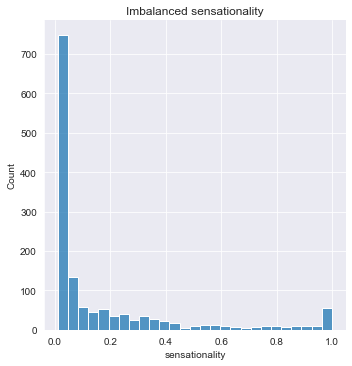

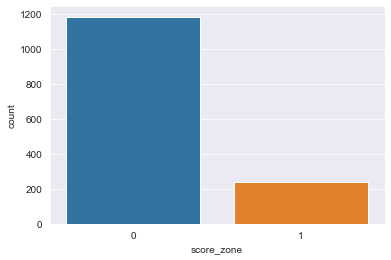

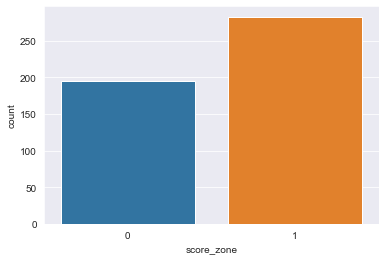

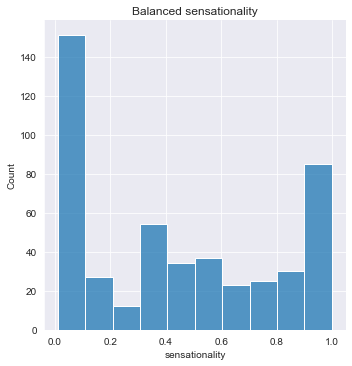

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,var_segment_loudness_max_end_diff,mean_segment_num_pitches,var_segment_num_pitches,mean_segment_num_pure_pitches,var_segment_num_pure_pitches,mean_segment_timbre,var_segment_timbre,num_tatums,mean_tatum_duration,var_tatum_duration
563,-1.185416,0.230687,0.577356,0.513133,1.192798,-1.284487,-0.824781,-0.196856,-0.153169,1.114639,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
699,-0.936879,0.745452,0.122764,0.790982,0.165289,-1.284487,-0.189520,-0.733094,-0.153169,0.157806,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
368,0.849986,1.154623,0.651073,0.513133,1.309507,0.778521,-0.726988,-0.549738,-0.153169,-0.235729,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
12,-0.079691,1.517598,-0.221250,1.346680,0.023376,-1.284487,-0.667357,-0.473471,-0.153169,4.710476,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
718,0.099234,-0.759244,0.823081,-0.876113,0.697655,0.778521,-0.593416,-0.682513,-0.153169,-0.795168,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,0.537966,-0.515061,0.485209,1.068831,0.138535,0.778521,-0.792183,-0.852315,-0.153169,0.157806,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1285,0.472827,-0.409469,-1.572738,-0.042566,-0.299223,0.778521,-0.887592,1.399609,-0.153169,-0.359192,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1320,-0.141677,0.138294,0.976659,-1.153963,0.752714,0.778521,-0.690414,-0.741788,-0.153169,-0.802884,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0
1321,-0.064125,-0.257679,-0.024670,-0.876113,-0.690839,0.778521,-0.764356,-0.663940,-0.153169,1.322981,...,1.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,-1.0,1.0


In [290]:
balance_metric = 'sensationality'

sns.displot(pop_metrics[balance_metric])
plt.title('Imbalanced ' + balance_metric)
plt.show()

pop_metrics['score_zone'] = pop_metrics[balance_metric].apply(lambda x: 1 if x >= 0.35 else 0)
sns.countplot(pop_metrics['score_zone'])
plt.show()
hi_scores = pop_metrics[pop_metrics['score_zone'] == 1]
lo_scores = pop_metrics[pop_metrics['score_zone'] == 0]


lo_scores_sample = np.array(np.random.choice(data_df.index, len(hi_scores), replace = False))
lo_scores = pop_metrics.iloc[lo_scores_sample]

# pm and df are the balanced versions of pop_metrics and data_df
# pm_samples = sample(pop_metrics[balance_metric], n=400)
# pm = pop_metrics.iloc[pm_samples.index]
pm = pd.concat([lo_scores, hi_scores])
df = data_df.iloc[pm.index]

sns.countplot(pm['score_zone'])
plt.show()
sns.displot(pm[balance_metric])
plt.title("Balanced " + balance_metric)
plt.show()
pop_metrics.drop(labels="score_zone", axis=1, inplace=True)
# y_train = sample(pop_metrics['avg_rank_score'], n=200, plot=True)
# X_train = data_df.iloc[y_train.index]

# pop_metrics[pop_metrics.columns] = StandardScaler().fit_transform(pop_metrics)
# pm[pm.columns] = StandardScaler().fit_transform(pm)    # scale the y-variables, testing multiple with different scales
#                                                        # X should already be scaled


# using the balanced data as the training set, we then use all remaining data for testing
X_train = df
y_train = pm

# test data is all data not used for training
y_test = pop_metrics.loc[~pop_metrics.index.isin(y_train.index)]
X_test = data_df.loc[~data_df.index.isin(X_train.index)]

# X_train, X_test, y_train, y_test = train_test_split(df, pm, train_size=0.9)

X_train_idx = list(X_train.index)
X_test_idx = list(X_test.index)
y_train_idx = list(y_train.index)
y_test_idx = list(y_test.index)
X_train

## Running Linear Regression Models

This will take a long time to run

In [291]:
def run(mdl, X: pd.DataFrame, y, y_name, forward=True, backward=True, verbose=0):
    tic = time.time()
    # features = [f for f in regression_features[y_name][0]]
    # X = X[features]
    print(f"Starting test metric = {y_name}\nnum X features = {len(X.columns)}\nX_features={X.columns}")
    results = []
    if forward:
        for f in range(MIN_PREDICTORS, MAX_PREDICTORS + 1):
            _, predictors_mask = stepwise_selection(mdl['model'], X, y, direction='forward', num_features=f)
            predictors = X.loc[:, predictors_mask==True]
            best_params, best_score = gscv(mdl['model'], mdl['cv'], predictors, y, score_method='neg_root_mean_squared_error', verbose=verbose)
            results.append({"model": mdl['model'], "best_params": best_params, "best_score": best_score, "features": list(predictors.columns), "features_mask": predictors_mask, "feature_selection_method": "forward_selection", "num_features": f, "y_name": y_name, "base": mdl['base']})
            print(f"model: {mdl['model']}, best_params: {best_params}, best_score: {best_score}, forward_num_features: {f}, y: {y_name}")

    if backward:
        for f in range(MIN_PREDICTORS, MAX_PREDICTORS + 1):
            _, predictors_mask = stepwise_selection(mdl['model'], X, y, direction='backward', num_features=f)
            predictors = X.loc[:, predictors_mask==True]
            best_params, best_score = gscv(mdl['model'], mdl['cv'], predictors, y, score_method='neg_root_mean_squared_error', verbose=verbose)
            results.append({"model": mdl['model'], "best_params": best_params, "best_score": best_score, "features": list(predictors.columns), "features_mask": list(predictors_mask), "feature_selection_method": "backward_selection", "num_features": f, "y_name": y_name, "base": mdl['base']})
            print(f"model: {mdl['model']}, best_params: {best_params}, best_score: {best_score}, backward_num_features: {f}, y: {y_name}")

    best_params, best_score = gscv(mdl['model'], mdl['cv'], X, y, score_method='neg_root_mean_squared_error', verbose=verbose)
    results.append({"model": mdl['model'], "best_params": best_params, "best_score": best_score, "features": X.columns, "features_mask": [], "feature_selection_method": "none", "num_features": -1, "y_name":  y_name, "base": mdl['base']})
    print(f"model: {mdl['model']}, best_params: {best_params}, best_score: {best_score}, num_features: {len(X.columns)}, y: {y_name}")

    toc = time.time()

    if verbose == 1:
        print(f"Processed {len(results)} in {toc-tic} seconds.")

    return results

In [ ]:
# TODO: Add pop_metrics.columns as all possible y_values
model_configs = {
    "models": [
    #     {"model": Ridge(),
    #      "base": Ridge,
    #      "cv": { 'alpha':[0.0001, 0.001, 0.01, 0.01, 1, 10.0],
    #              'fit_intercept':[True, False],
    #              'normalize':[True, False],
    #              'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    #              }
    #      },
    #     {"model": Lasso(),
    #      "base": Lasso,
    #      "cv": { 'max_iter': [10000],
    #              'alpha': [.0001, 0.001, 0.01, 0.01, 1, 10.0],
    #              'fit_intercept': [True, False],
    #              'normalize': [True, False],
    #              }
    #      },
    #     {"model": ElasticNet(),
    #      "base": ElasticNet,
    #      "cv": { 'max_iter': [10000],
    #              'l1_ratio':[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1, 10.0],
    #              'fit_intercept':[True, False],
    #              'normalize':[True, False],
    #              }
    #      },
    #     {"model": LinearRegression(), "base": LinearRegression, "cv": {}},

        {"model": SVR(),
         "base": SVR,
         "cv": {
             "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed"],
             "degree": [3, 4],
             "gamma": ["auto", "scale"],
             "epsilon": [0.001, 0.01, 0.1, 1],
             "max_iter": [-1],
             "cache_size": [800]
         }},
    ],
    "y": pop_metrics.columns,
}

tic = time.time()
all_models = []

for m in model_configs['models']:
    for y in model_configs['y']:
        y_train = pop_metrics[y].iloc[y_train_idx]
        all_models += run(m, X_train, y_train, y, forward=False, backward=False)
toc = time.time()
print(f"Processed {len(all_models)} models in {toc-tic} seconds.")
safety_save = all_models.copy()

Model: Ridge()
Params: {'alpha': 10.0, 'fit_intercept': False, 'normalize': False, 'solver': 'saga'}
CV Score: 0.02063409317125331
Num Features: 40
Y-Variable: debut_rank
Test MSE: 0.0119307122260908
Test R2: -20.203315264403564


Text(0, 0.5, 'debut_rank')

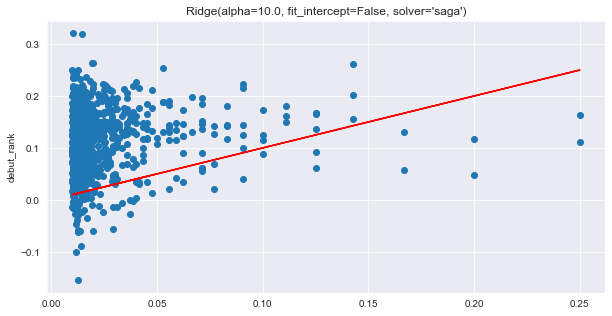

In [294]:
# dump(all_models, '../models/linear_regression/linear_regression_all_5.joblib')
# dump(all_models, '../models/linear_regression/linear_regression_all_4.joblib')
# dump(all_models, '../models/linear_regression/linear_regression_all_3.joblib')
all_models = load('../models/linear_regression/linear_regression_all.joblib')

from math import inf
hi = -inf
best_model = None
for am in all_models:
    if am['best_score'] > hi:
        hi = am['best_score']
        best_model = am


y_train = pop_metrics[best_model['y_name']].iloc[y_train_idx]
y_test = pop_metrics[best_model['y_name']].iloc[y_test_idx]

X_train = data_df[best_model['features']].iloc[X_train_idx]
X_test = data_df[best_model['features']].iloc[X_test_idx]

mdl = best_model['base'](**best_model['best_params'])
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)

print(f"Model: {best_model['model']}")
print(f"Params: {best_model['best_params']}")
print(f"CV Score: {best_model['best_score']}")
print(f"Num Features: {len(best_model['features'])}")
print(f"Y-Variable: {best_model['y_name']}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")
print(f"Test R2: {r2_score(y_test, y_pred)}")

fig = plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
plt.plot(y_test,y_test,'r')
plt.title(f"{mdl}")
plt.ylabel(best_model['y_name'])

In [ ]:
mdl = best_model['base'](**best_model['best_params'])
mdl.fit(data_df[best_model['features']], pop_metrics[best_model['y_name']])
y_pred = mdl.predict(X_test)

model_config = {
    "model": mdl,
    "features": best_model['features']
}

# dump(model_config, '../models/linear_regression/linear_regression_all_best_3.joblib')
# dump(model_config, '../models/linear_regression/linear_regression_all_best_4.joblib')
# dump(model_config, '../models/linear_regression/linear_regression_all_best_5.joblib')

# print(f"Model: {best_model['model']}")
# print(f"Params: {best_model['best_params']}")
# print(f"CV Score: {best_model['best_score']}")
# print(f"Num Features: {len(best_model['features'])}")
# print(f"Y-Variable: {best_model['y_name']}")
# print(f"Test MSE: {mean_squared_error(y_test, y_pred)}")
# print(f"Test R2: {r2_score(y_test, y_pred)}")
#
# fig = plt.figure(figsize=(10,5))
# plt.scatter(y_test, y_pred)
# plt.plot(y_test,y_test,'r')
# plt.title(f"{mdl}")
# plt.ylabel(best_model['y_name'])
mdl.coef_

In [ ]:
data_df

In [ ]:
np.arange(12, 0, -1)